<a href="https://colab.research.google.com/github/sumitsontakke/deep_learning/blob/main/ANN/end_to_end/base_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import TopKCategoricalAccuracy

from sklearn.model_selection import train_test_split

In [2]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape, X_train.dtype, y_train.dtype)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
X_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1) uint8 int64
X_test shape: (10000, 32, 32, 3) y_test shape: (10000, 1)


In [3]:
print(X_train[0][0][0], y_train[0:10].flatten(), np.unique(y_train))

[255 255 255] [19 29  0 11  1 86 90 28 23 31] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


<function matplotlib.pyplot.show(close=None, block=None)>

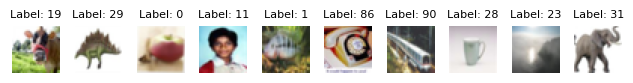

In [4]:
# Visualize first 10 images
# plt.figure(figsize=(3,15))
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(X_train[i])
  plt.title(f"Label: {y_train[i][-1]}", fontsize=8)
  plt.axis("off")
plt.tight_layout()
plt.show

Label Format | Loss Function
--- | ---
One-hot encoded | categorical_crossentropy
Integer encoded (0–99) | sparse_categorical_crossentropy

For large number of classes (100 in this case), it will be memory efficient to keep labels and integers and use
```python
loss='sparse_categorical_crossentropy'
```


In [5]:
splitds = train_test_split(X_train, y_train, test_size=0.3,random_state=42)

In [6]:
splitds[0].shape, splitds[1].shape, splitds[2].shape, splitds[3].shape

((35000, 32, 32, 3), (15000, 32, 32, 3), (35000, 1), (15000, 1))

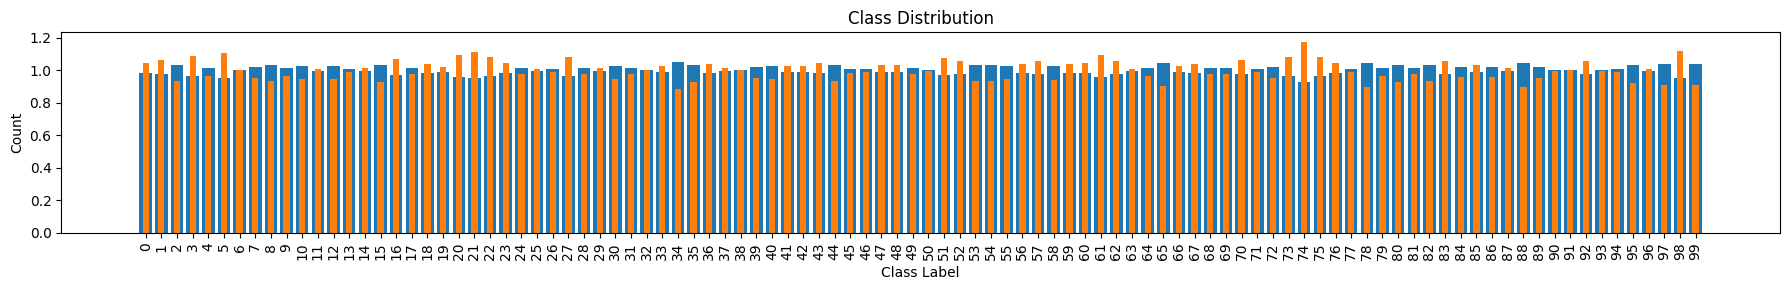

In [7]:
y_training_counts = np.bincount(splitds[2].flatten())
ytrain_pct = y_training_counts / y_training_counts.sum() * 100
y_val_counts = np.bincount(splitds[3].flatten())
yval_pct = y_val_counts / y_val_counts.sum() * 100
y_labels = list(range(100))

plt.figure(figsize=(18,3))
plt.bar(x=y_labels, height=ytrain_pct, width=0.8)
plt.bar(x=y_labels, height=yval_pct, width=0.4)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(y_labels, rotation=90)
plt.tight_layout()
plt.show()

In [8]:
splitdss = train_test_split(X_train, y_train, test_size=0.3,random_state=42, stratify=y_train)
splitdss[0].shape, splitdss[1].shape, splitdss[2].shape, splitdss[3].shape

((35000, 32, 32, 3), (15000, 32, 32, 3), (35000, 1), (15000, 1))

In [9]:
x_labels = list(range(100))
ytrain_count = np.bincount(splitdss[2].ravel())
ytrain_count

array([350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350,
       350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350,
       350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350,
       350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350,
       350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350,
       350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350,
       350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350,
       350, 350, 350, 350, 350, 350, 350, 350, 350])

In [10]:
np.bincount(y_train.flatten())

array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500])

---

## Model

Decision Point | Guideline
--- | ---
🔢 Number of hidden layers | 2–4 layers for starting ANN model
💡 Neurons per layer | Start with 512 → 256 → 128 pattern (powers of 2)
🧂 Add BatchNorm? | Yes, especially after Dense+ReLU
💧 Dropout? | Yes, e.g., Dropout(0.3–0.5) to avoid overfitting
🧠 Activation functions | ReLU works well; softmax for final
🏁 Final layer | Dense(100, activation='softmax')

In [11]:
def build_model(learning_rate=0.01):
  model = Sequential()
  model.add(Flatten(input_shape=(32,32,3)))
  for neurons, dr in [(512, 0.3), (256, 0.3), (128, 0.3)]:
    model.add(Dense(neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))
  model.add(Dense(100, activation="softmax"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="sparse_categorical_crossentropy", metrics=['accuracy', TopKCategoricalAccuracy(k=5)])

  return model

base_model = build_model()
base_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,754,084 (6.69 MB)

 Trainable params: 1,752,292 (6.68 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [12]:
ann_trained = base_model.fit(X_train, y_train, epochs=40, batch_size=200, validation_split=0.3, verbose=1)

Epoch 1/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.0496 - loss: 4.4470 - top_k_categorical_accuracy: 0.0576 - val_accuracy: 0.1015 - val_loss: 3.8860 - val_top_k_categorical_accuracy: 0.0738
Epoch 2/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1101 - loss: 3.8098 - top_k_categorical_accuracy: 0.0496 - val_accuracy: 0.1147 - val_loss: 3.7981 - val_top_k_categorical_accuracy: 0.0104
Epoch 3/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1316 - loss: 3.6804 - top_k_categorical_accuracy: 0.0446 - val_accuracy: 0.1017 - val_loss: 3.9724 - val_top_k_categorical_accuracy: 0.0261
Epoch 4/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1415 - loss: 3.6284 - top_k_categorical_accuracy: 0.0480 - val_accuracy: 0.1483 - val_loss: 3.6123 - val_top_k_categorical_accuracy: 0.0673
Epoch 5/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1529 - loss: 3.5507 - top_k_categorical_accuracy: 0.0462 - val_accuracy: 0.1393 - val_loss: 3.7050 - val_top

In [13]:
# Evalaute base_model
base_model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2145 - loss: 3.4704 - top_k_categorical_accuracy: 0.0370


[3.4660558700561523, 0.21610000729560852, 0.03689999878406525]

In [14]:
base_model.save("cifar10_base_ann.keras", overwrite=True)

In [19]:
ann_trained.history.keys()

dict_keys(['accuracy', 'loss', 'top_k_categorical_accuracy', 'val_accuracy', 'val_loss', 'val_top_k_categorical_accuracy'])

In [23]:
str(ann_trained.epoch)

'[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]'

In [33]:
ann_metric_df = pd.DataFrame({
    "epochs": ann_trained.epoch,
    "accuracy": ann_trained.history["accuracy"],
    "loss": ann_trained.history["loss"],
    "val_accuracy": ann_trained.history["val_accuracy"],
    "val_loss": ann_trained.history["val_loss"],
    "top_k_categorical_accuracy": ann_trained.history["top_k_categorical_accuracy"],
    })

ann_metric_df

,epochs,accuracy,loss,val_accuracy,val_loss,top_k_categorical_accuracy
0,0,0.067486,4.174543,0.101467,3.886038,0.059400
1,1,0.114486,3.786544,0.114733,3.798116,0.051229
2,2,0.131914,3.682947,0.101667,3.972421,0.048714
3,3,0.144000,3.618383,0.148267,3.612283,0.048343
4,4,0.152400,3.559607,0.139333,3.704959,0.048171
5,5,0.161086,3.519577,0.171800,3.545086,0.047143
6,6,0.169200,3.492760,0.157800,3.639315,0.047771
7,7,0.170600,3.460587,0.173667,3.564185,0.048686
8,8,0.177314,3.430671,0.188667,3.456487,0.048743
9,9,0.179314,3.413088,0.161933,3.623834,0.047771


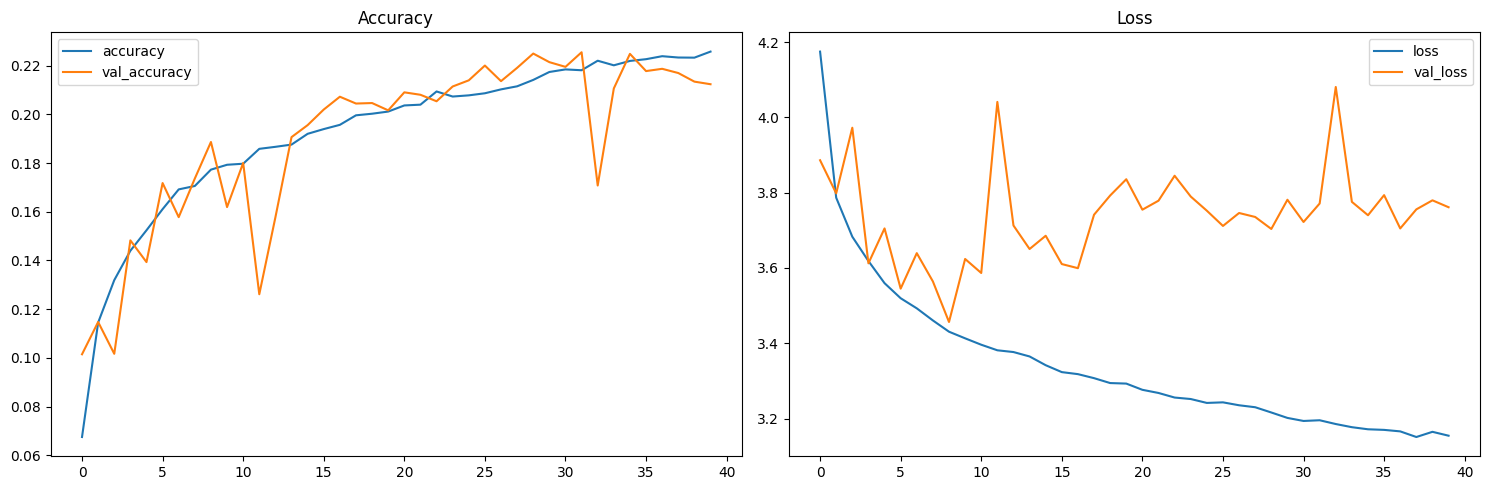

In [39]:
# plot accuracy and loss plot side by side using subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(ann_metric_df["epochs"], ann_metric_df["accuracy"], label="accuracy")
axs[0].plot(ann_metric_df["epochs"], ann_metric_df["val_accuracy"], label="val_accuracy")
axs[0].set_title("Accuracy")
axs[0].legend()
axs[1].plot(ann_metric_df["epochs"], ann_metric_df["loss"], label="loss")
axs[1].plot(ann_metric_df["epochs"], ann_metric_df["val_loss"], label="val_loss")
axs[1].set_title("Loss")
axs[1].legend()
plt.tight_layout()
plt.show()